# Automated Detection and Segmentation of Retinal Cysts in OCT Images

### 1. Loading libraries and input images

In [10]:
import numpy as np
import pandas as pd
from skimage import io, img_as_float, img_as_ubyte, restoration, measure
from skimage.filters.thresholding import *
from skimage.morphology import binary_opening, remove_small_objects, disk, binary_closing
from skimage.measure import label, regionprops, regionprops_table
import matplotlib.pyplot as plt
from skimage.exposure import equalize_adapthist, match_histograms
from skimage.segmentation import clear_border, watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.filters import rank, gaussian
from PIL import Image
import glob
import os

In [11]:
image_folder = "img_dir"
image_paths = sorted(glob.glob(os.path.join(image_folder, "*.tif")))[:10]
print(f"Found {len(image_paths)} images")

# Store results at each stage
images = {}
image_shape = {}
binary_images = {}
threshold_values = {}
labeled_images = {}
dataframes = {}
filtered_dataframes = {}
output_masks = {}
final_outputs = {}

Found 10 images


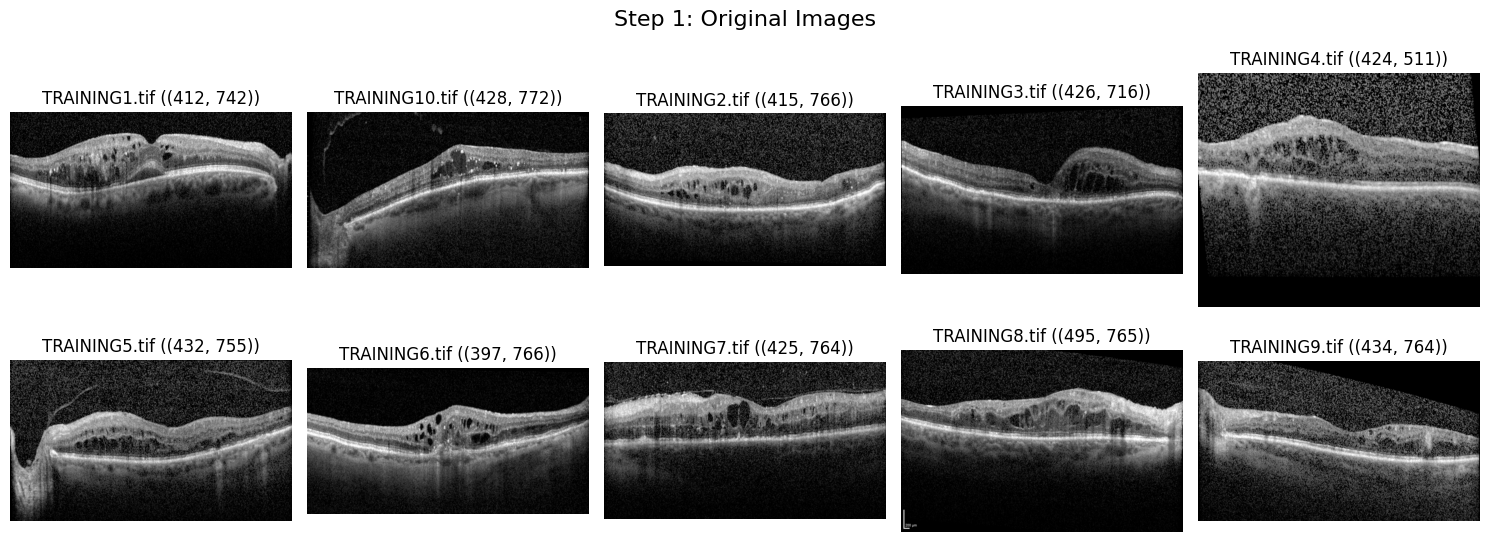

In [12]:
for i, path in enumerate(image_paths):
    img_name = os.path.basename(path)
    images[img_name] = np.array(Image.open(path))
    image_shape[img_name] = images[img_name].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Step 1: Original Images", fontsize=16)
for idx, (name, img) in enumerate(images.items()):
    ax = axes[idx // 5, idx % 5]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{name[:15]} ({image_shape[name]})")
    ax.axis('off')
plt.tight_layout()
plt.show()

### 2. Preprocessing with Reference-Based Histogram Matching

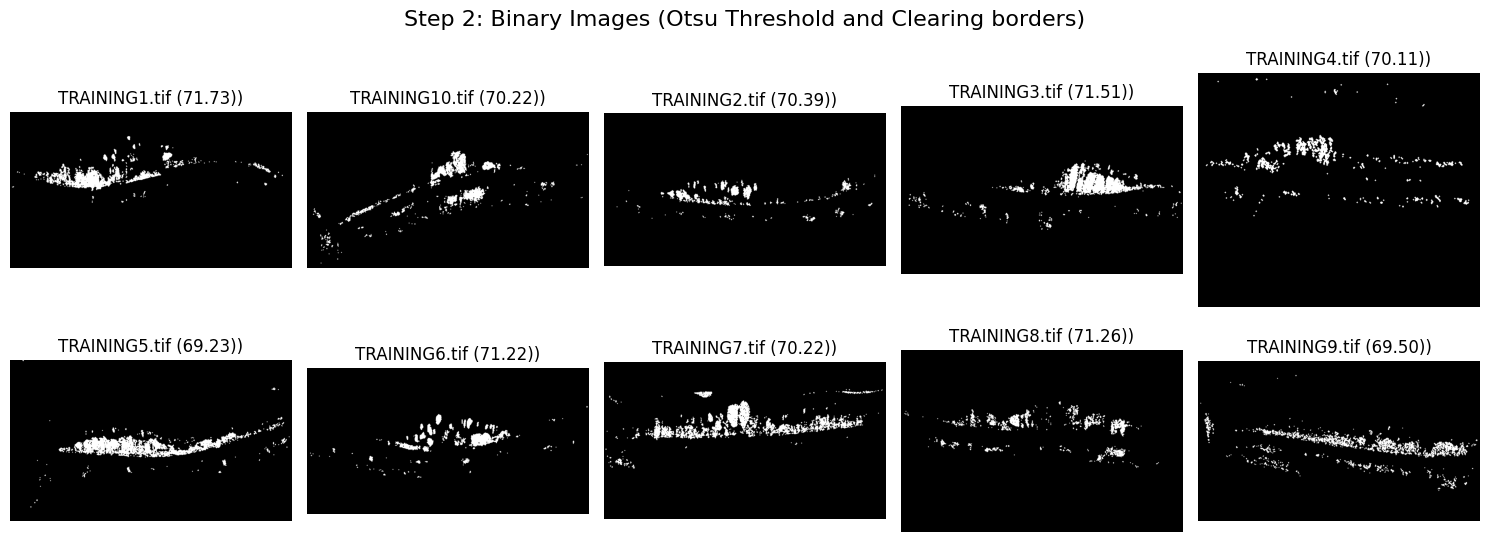

In [13]:
for name, img in images.items():
    # Clean the data by applying match_histograms of the cleanest image: 'TRAINING6.tif'
    im = io.imread('img_dir/TRAINING6.tif')
    im = img_as_float(im)

    # # Apply logarithmic-type transformation
    a = 0.05
    c = 255 / np.log(1 + np.abs(im.max()))
    im_ref = c * (np.power(1 + a, im) - 1)
    im_ref = img_as_ubyte(im_ref / im_ref.max())  # scale to [0,1] before converting
    im_org = img_as_ubyte(img / img.max())

    # Perform histogram matching
    img = match_histograms(im_org, im_ref)

    # Apply Otsu threshold
    thres_img = threshold_otsu(img)
    binary = img <= thres_img
    binary = binary_opening(binary, disk(1))

    binary = clear_border(binary)
    binary_images[name] = binary
    threshold_values[name] = thres_img

# Visualize binary images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Step 2: Binary Images (Otsu Threshold and Clearing borders)", fontsize=16)
for idx, (name, img) in enumerate(binary_images.items()):
    ax = axes[idx // 5, idx % 5]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{name[:15]} ({threshold_values[name]:.2f}))")
    ax.axis('off')
plt.tight_layout()
plt.show()

### 3. Segmentation


TRAINING1.tif:
  Total regions detected: 457
  Area range: 2.00 to 552.00

TRAINING10.tif:
  Total regions detected: 511
  Area range: 1.00 to 507.00

TRAINING2.tif:
  Total regions detected: 336
  Area range: 1.00 to 239.00

TRAINING3.tif:
  Total regions detected: 473
  Area range: 1.00 to 508.00

TRAINING4.tif:
  Total regions detected: 366
  Area range: 1.00 to 52.00

TRAINING5.tif:
  Total regions detected: 640
  Area range: 1.00 to 429.00

TRAINING6.tif:
  Total regions detected: 264
  Area range: 2.00 to 408.00

TRAINING7.tif:
  Total regions detected: 892
  Area range: 1.00 to 261.00

TRAINING8.tif:
  Total regions detected: 569
  Area range: 1.00 to 143.00

TRAINING9.tif:
  Total regions detected: 1060
  Area range: 1.00 to 102.00


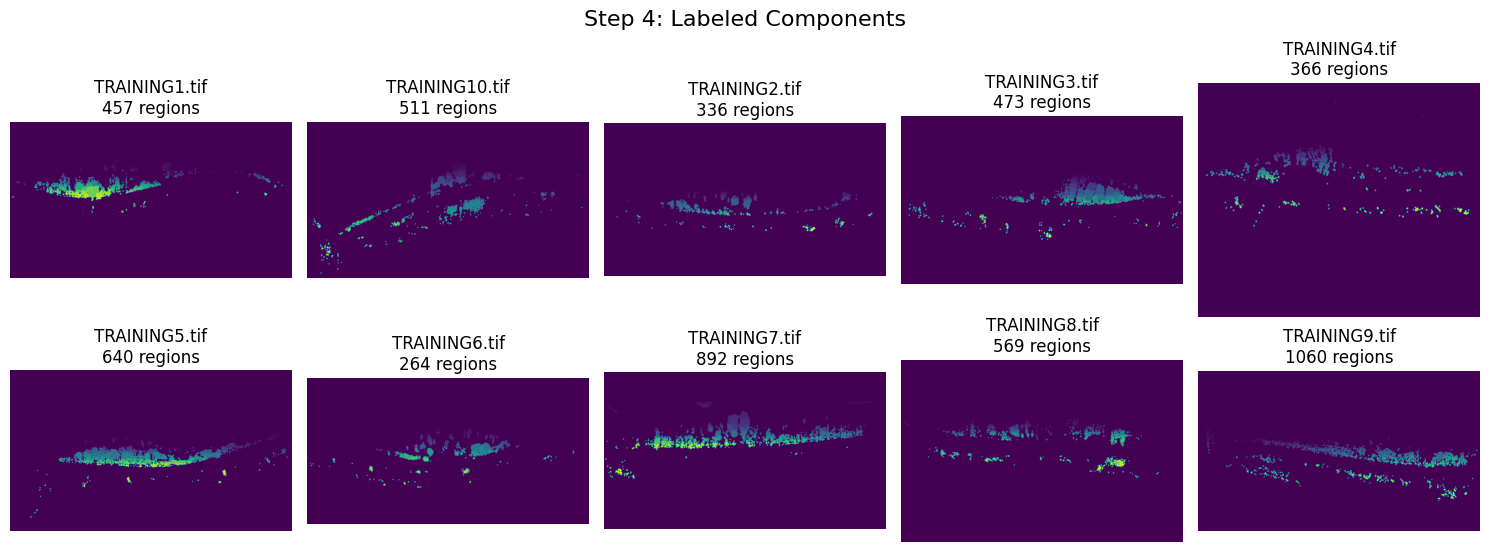

In [14]:
for name, binary_cleaned in binary_images.items():
    # Label connected components
    distance = ndi.distance_transform_edt(binary_cleaned)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary_cleaned)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers = ndi.label(mask)[0]
    labeled = watershed(-distance, markers, mask=binary_cleaned)
    
    labeled_images[name] = labeled

    img = images[name]

    props = regionprops_table(
        labeled,
        intensity_image=img,
        properties=[
            'label', 'area','intensity_mean', 'eccentricity']
    )
    df = pd.DataFrame(props)
    dataframes[name] = df

    print(f"\n{name}:")
    print(f"  Total regions detected: {len(df)}")
    print(f"  Area range: {df['area'].min():.2f} to {df['area'].max():.2f}")

# Visualize labeled images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Step 4: Labeled Components", fontsize=16)
for idx, (name, img) in enumerate(labeled_images.items()):
    ax = axes[idx // 5, idx % 5]
    ax.imshow(img)
    ax.set_title(f"{name[:15]}\n{labeled_images[name].max()} regions")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [15]:
for name, df in dataframes.items():
    # Filtering the area and intensity_mean
    df_filtered = df[
    (df['area'] >= df['area'].mean()) # Filtering out the small objects
    & (df['intensity_mean'] <= df['intensity_mean'].mean()) # Filtering out the darker/black
    # & (df['solidity'] <= 0.8) & (df['solidity'] >= 0.5)
    # & (df['eccentricity'] < 0.85)
    ]
    area_min_threshold = df['area'].mean()
    intensity_mean_min = df['intensity_mean'].mean()

    print(f"\n{name}:")
    print(f"Applying filters:")
    print(f"Area range: >= {area_min_threshold:.2f}")
    print(f"Intensity mean: <= {intensity_mean_min :.2f}")

    print(df_filtered.head())
    filtered_dataframes[name] = df_filtered



TRAINING1.tif:
Applying filters:
Area range: >= 21.22
Intensity mean: <= 50.24
   label  area  intensity_mean  eccentricity
0      1  68.0       24.985294      0.674654
3      4  36.0       37.972222      0.587202
4      5  25.0       46.800000      0.693235
5      6  78.0       23.948718      0.731272
6      7  33.0       43.424242      0.723015

TRAINING10.tif:
Applying filters:
Area range: >= 18.75
Intensity mean: <= 54.08
    label  area  intensity_mean  eccentricity
2       3  22.0       52.181818      0.464826
5       6  27.0       53.222222      0.639441
6       7  83.0       52.650602      0.858220
9      10  85.0       54.011765      0.872672
10     11  32.0       49.937500      0.724221

TRAINING2.tif:
Applying filters:
Area range: >= 16.66
Intensity mean: <= 59.69
    label  area  intensity_mean  eccentricity
14     15  21.0       52.285714      0.744180
16     17  50.0       47.960000      0.834295
19     20  46.0       34.826087      0.783419
20     21  44.0       45.8409

### 4. Postprocessing

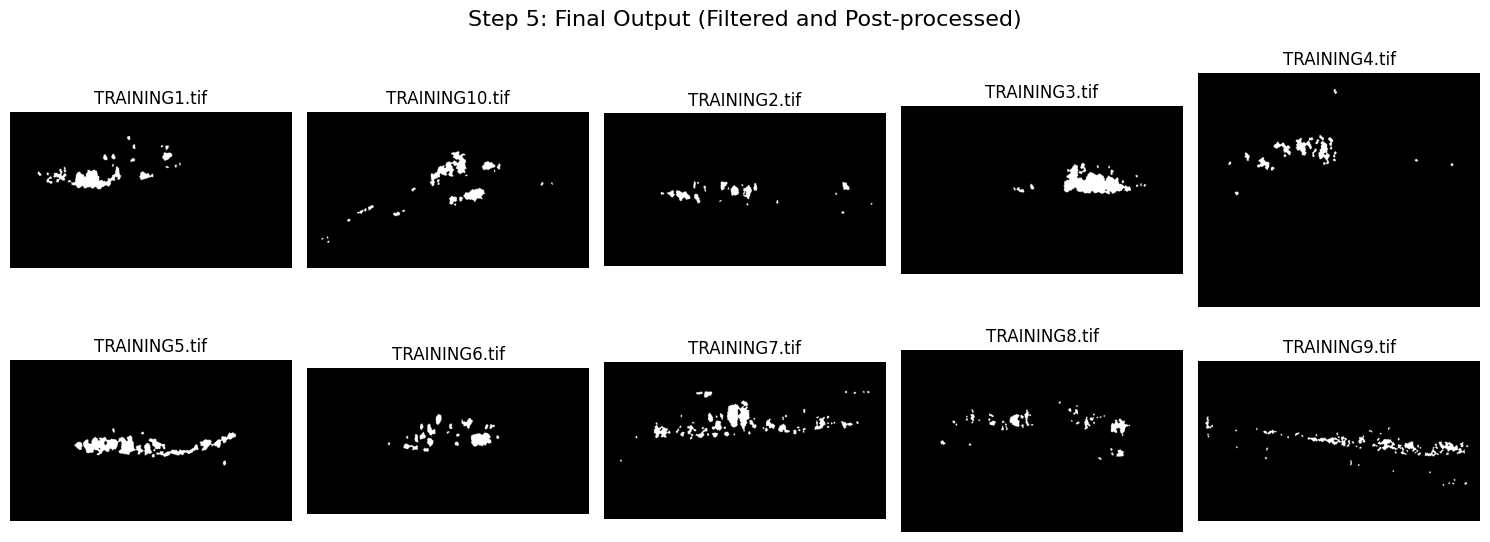

In [16]:
for name in binary_images.keys():
    binary_cleaned = binary_images[name]
    labeled = labeled_images[name]
    df_filtered = filtered_dataframes[name]

    # Create output mask using filtered labels
    output_mask = np.zeros_like(binary_cleaned)
    for idx, row in df_filtered.iterrows():
        output_mask[labeled == row['label']] = True

    # POST-PROCESSING
    # 1. Fill small holes inside cysts
    output_mask = binary_closing(output_mask, disk(2))

    # 2. Remove very small objects
    output_mask = remove_small_objects(output_mask, min_size=15)

    output_masks[name] = output_mask

    output = (output_mask * 255).astype(np.uint8)
    final_outputs[name] = output

# Visualize final outputs
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Step 5: Final Output (Filtered and Post-processed)", fontsize=16)
for idx, (name, img) in enumerate(final_outputs.items()):
    ax = axes[idx // 5, idx % 5]
    ax.imshow(img, cmap='gray')
    dot_count = len(filtered_dataframes[name])
    ax.set_title(f"{name[:15]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

### 5. Calculating Dice Coefficient

In [17]:
annotation_folder = "ann_dir"
annotation_paths = sorted(glob.glob(os.path.join(annotation_folder, "*.tif")))[:10]

expected_outputs = {}

for i, path in enumerate(annotation_paths):
    img_name = os.path.basename(path)
    expected_outputs[img_name] = np.array(Image.open(path))

def calculate_dice(predicted, ground_truth):

    # Convert to binary (0 and 1)
    pred_binary = (predicted > 0).astype(np.uint8)

    # Handle RGB images by converting to grayscale first
    if len(ground_truth.shape) == 3:
        gt_gray = np.mean(ground_truth, axis=2)
    else:
        gt_gray = ground_truth

    gt_binary = (gt_gray > 0).astype(np.uint8)

    # Calculate True Positives, False Positives, False Negatives
    TP = np.sum((pred_binary == 1) & (gt_binary == 1))
    FP = np.sum((pred_binary == 1) & (gt_binary == 0))
    FN = np.sum((pred_binary == 0) & (gt_binary == 1))

    # Dice Coefficient = 2*TP / (2*TP + FP + FN)
    dice = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0

    return dice

# Calculate Dice for each image
dice_scores = {}

print("="*60)
print("DICE COEFFICIENT SCORES")
print("="*60)

for name in final_outputs.keys():
    if name in expected_outputs:
        predicted = final_outputs[name]
        ground_truth = expected_outputs[name]

        dice = calculate_dice(predicted, ground_truth)
        dice_scores[name] = dice

        print(f"{name}: {dice:.4f}")
    else:
        print(f"Warning: {name} not found in expected outputs")

# Calculate mean Dice
if dice_scores:
    mean_dice = np.mean(list(dice_scores.values()))
    std_dice = np.std(list(dice_scores.values()))

    print("\n" + "="*60)
    print(f"MEAN DICE COEFFICIENT: {mean_dice:.4f} ± {std_dice:.4f}")
    print("="*60)

DICE COEFFICIENT SCORES
TRAINING1.tif: 0.3043
TRAINING10.tif: 0.5722
TRAINING2.tif: 0.7251
TRAINING3.tif: 0.7534
TRAINING4.tif: 0.5821
TRAINING5.tif: 0.6205
TRAINING6.tif: 0.7041
TRAINING7.tif: 0.6095
TRAINING8.tif: 0.4565
TRAINING9.tif: 0.3576

MEAN DICE COEFFICIENT: 0.5685 ± 0.1444


### 6. Comparing results

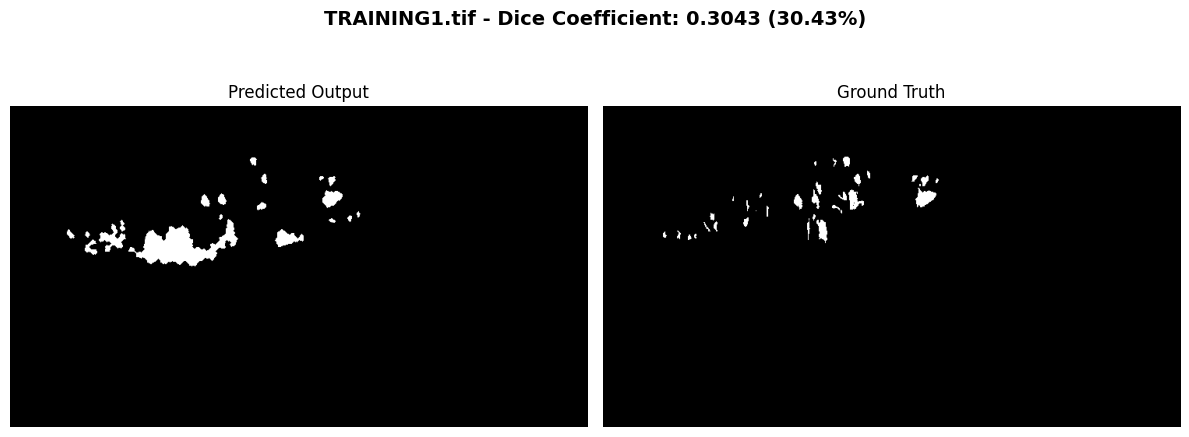

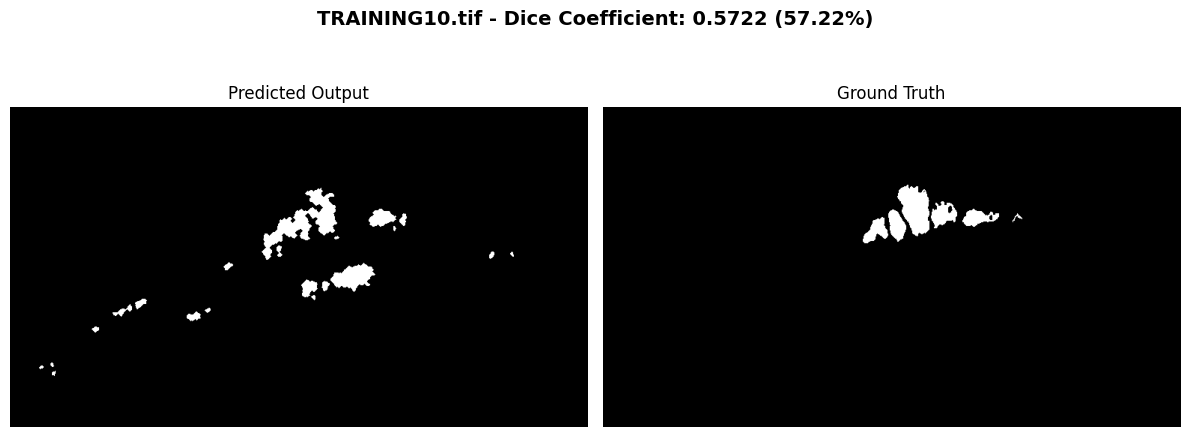

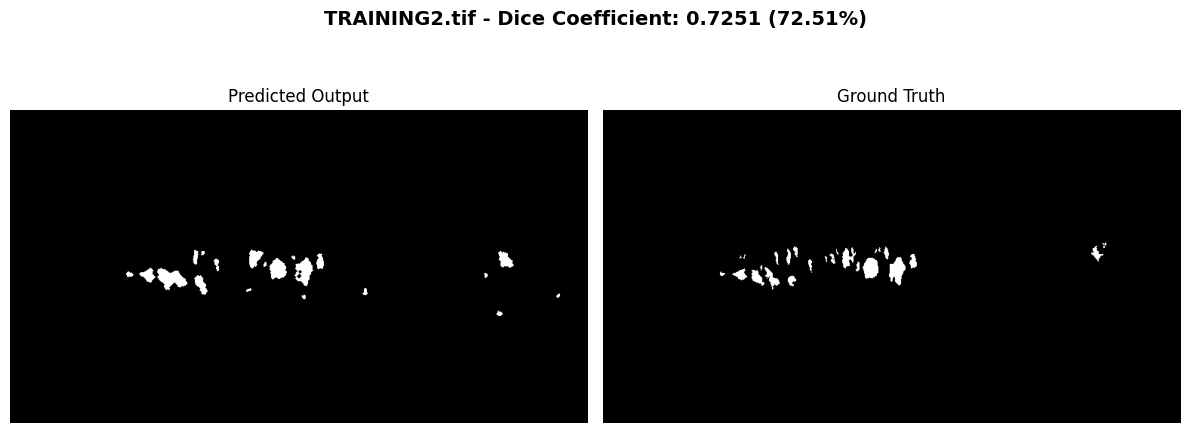

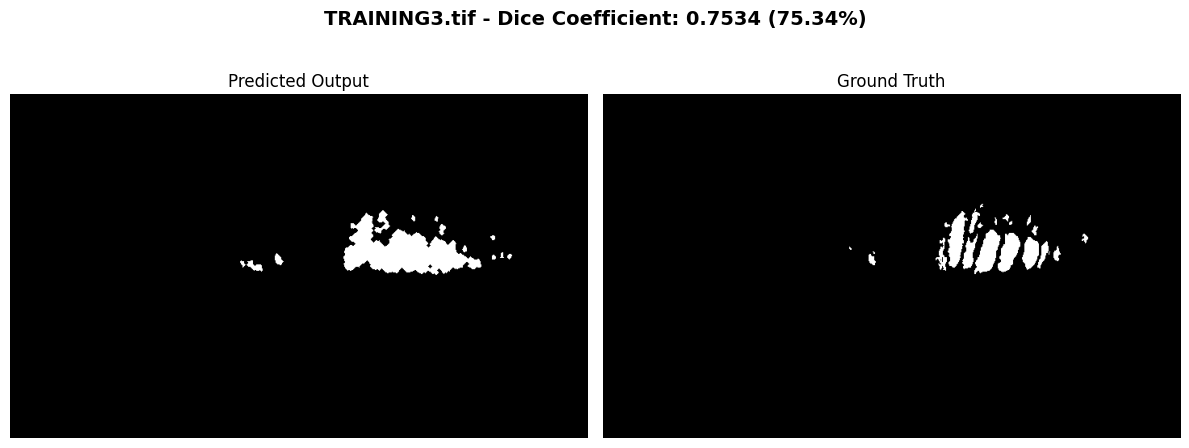

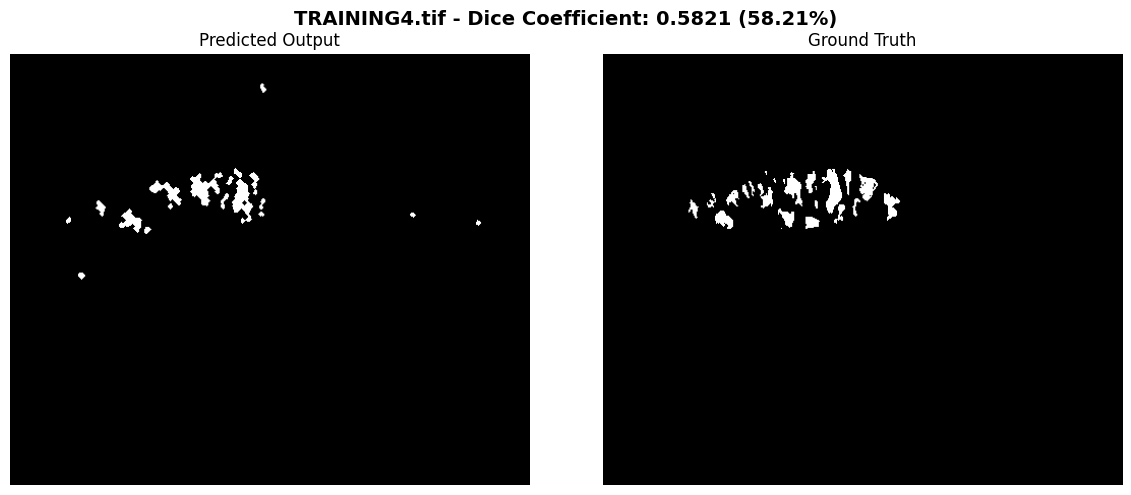

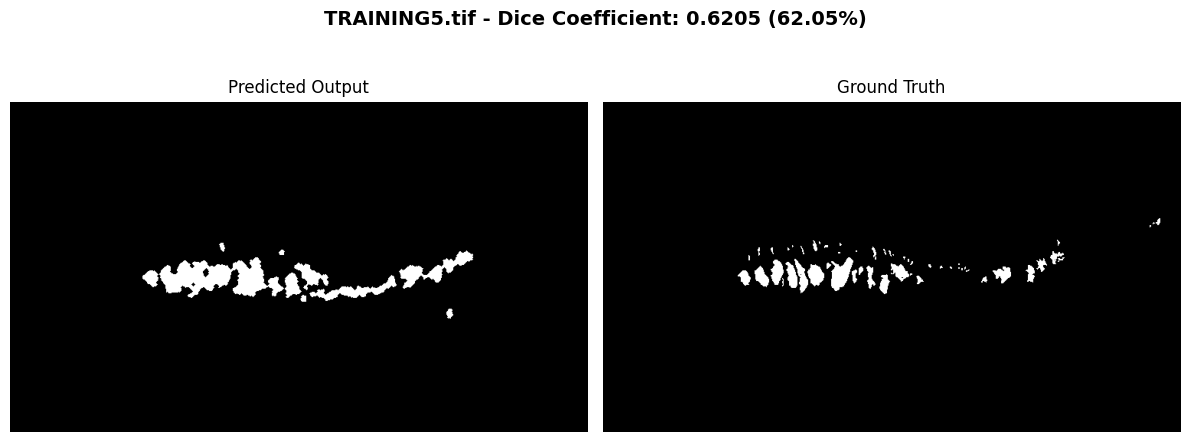

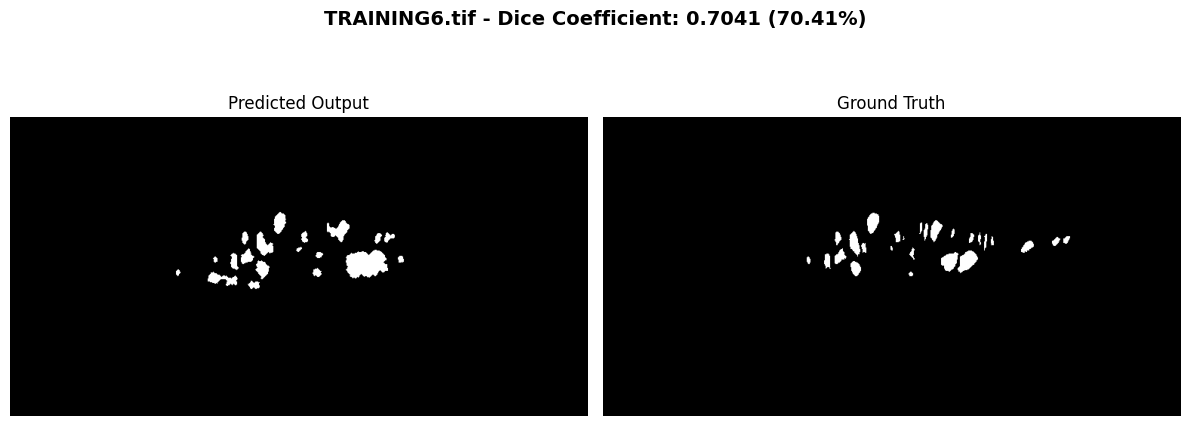

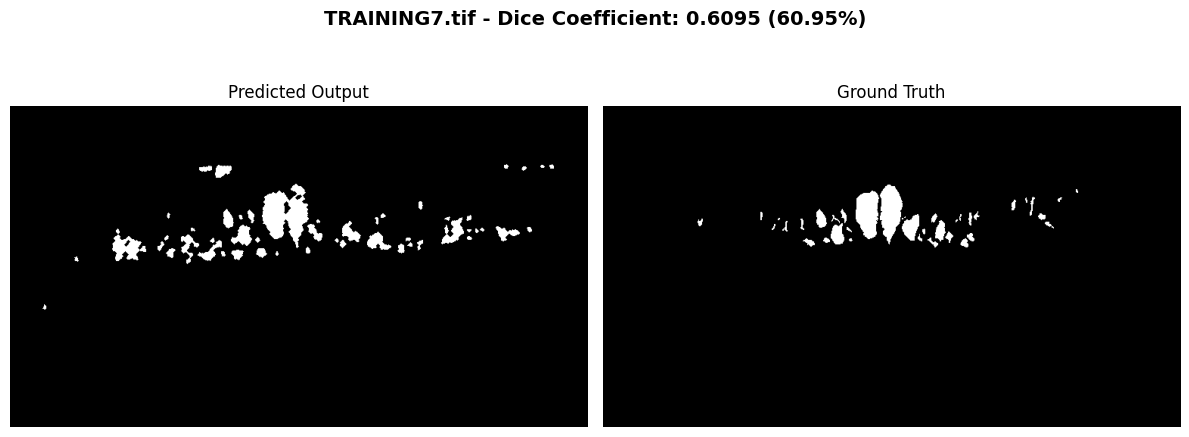

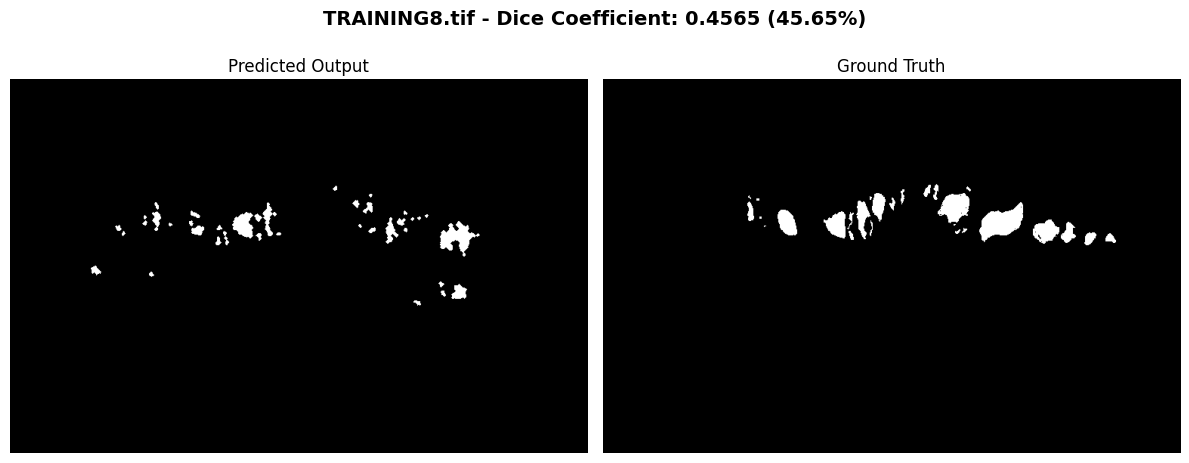

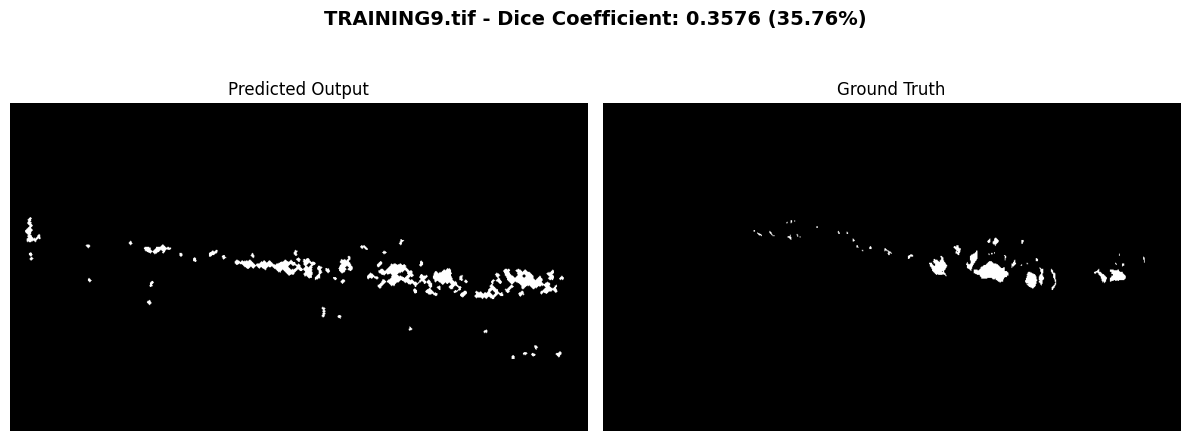

In [18]:
for name in final_outputs.keys():
    if name in expected_outputs:
        dice = dice_scores[name]
        dice_percent = dice * 100

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(f"{name} - Dice Coefficient: {dice:.4f} ({dice_percent:.2f}%)", fontsize=14, fontweight='bold')

        # Predicted output
        axes[0].imshow(final_outputs[name], cmap='gray')
        axes[0].set_title('Predicted Output')
        axes[0].axis('off')

        # Ground truth
        axes[1].imshow(expected_outputs[name], cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()